# Leveraging Experiment Lines to Data Analytics

## Time Series regression - tune - example

Our objective here is to generate a model that is able to do time series forecasting.

Configuring the environment:

In [1]:
# DAL ToolBox
# version 1.01.727

source("https://raw.githubusercontent.com/cefet-rj-dal/daltoolbox/main/jupyter.R")

#loading DAL Toolbox
load_library("daltoolbox")

#load required library
library(ggplot2)

Loading required package: daltoolbox

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘daltoolbox’


The following object is masked from ‘package:base’:

    transform




### Cosine time series for studying

Generate a cosine time series to use in the example, it starts at 0 (zero) and goes up to 25 (twenty-five).

In [2]:
i <- seq(0, 25, 0.25)
x <- cos(i)

Plots the time series:

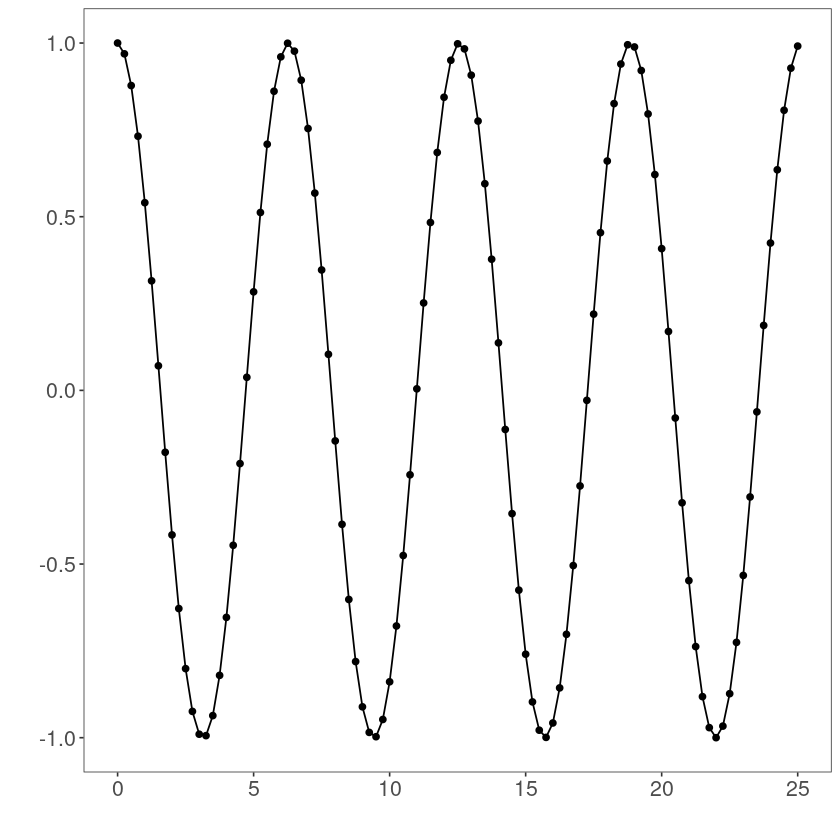

In [3]:
plot_ts(x=i, y=x) + theme(text = element_text(size=16))

### Sliding windows

Creates a matrix representing a sliding window to be used in the process of training the model. Each row of the matrix represents one moment of the sliding window, with 10 (ten) elements as attributes (t9, t8, t7, ..., t0).

In [4]:
sw_size <- 10
ts <- ts_data(x, sw_size)
ts_head(ts, 3)

t9,t8,t7,t6,t5,t4,t3,t2,t1,t0
1.0000000,0.9689124,0.8775826,0.7316889,0.5403023,0.3153224,0.0707372,-0.1782461,-0.4161468,-0.6281736
0.9689124,0.8775826,0.7316889,0.5403023,0.3153224,0.0707372,-0.1782461,-0.4161468,-0.6281736,-0.8011436
0.8775826,0.7316889,0.5403023,0.3153224,0.0707372,-0.1782461,-0.4161468,-0.6281736,-0.8011436,-0.9243024


### Data sampling

Samples data into train and test.

In [5]:
test_size <- 1
samp <- ts_sample(ts, test_size)
ts_head(samp$train, 3)
ts_head(samp$test)

t9,t8,t7,t6,t5,t4,t3,t2,t1,t0
1.0000000,0.9689124,0.8775826,0.7316889,0.5403023,0.3153224,0.0707372,-0.1782461,-0.4161468,-0.6281736
0.9689124,0.8775826,0.7316889,0.5403023,0.3153224,0.0707372,-0.1782461,-0.4161468,-0.6281736,-0.8011436
0.8775826,0.7316889,0.5403023,0.3153224,0.0707372,-0.1782461,-0.4161468,-0.6281736,-0.8011436,-0.9243024


t9,t8,t7,t6,t5,t4,t3,t2,t1,t0
-0.7256268,-0.532833,-0.3069103,-0.06190529,0.1869486,0.424179,0.635036,0.8064095,0.9276444,0.9912028


### Model training

Tune optimizes a learner hyperparameter, no matter which one. This way, in this example, an ELM is used in the hyperparameters tuning using an appropriate range. The result of tunning is an ELM model for the training set.

In [6]:
# Setup for tunning using ELM
tune <- ts_tune(input_size=c(3:5), base_model = ts_elm(ts_norm_gminmax()))
ranges <- list(nhid = 1:5, actfun=c('sig', 'radbas', 'tribas', 'relu', 'purelin'))

In [6] is using ts_elm() as base_model, but all time series models can be used. It is simple as changing the constructor.

An LSTM could be used, as shown at In [7], as lines of comments. This example clarifies how to provide variability on workflow models by simply changing constructors.

Options of ranges for all time series models are presented in the end of this notebook.

Input size options should be between 1 and sw_size-2.

In [7]:
# tune <- ts_tune(input_size=c(3:5), base_model = ts_lstm(ts_norm_gminmax()))
# ranges <- list(input_size = 1:10, epochs=10000)

The prediction output using the training set can be used to evaluate the model's adjustment level to the training data:

In [8]:
io_train <- ts_projection(samp$train)

# Generic model tunning
model <- fit(tune, x=io_train$input, y=io_train$output, ranges)

### Evaluation of adjustment

In [9]:
adjust <- predict(model, io_train$input)
ev_adjust <- evaluate(model, io_train$output, adjust)
print(head(ev_adjust$metrics))

           mse        smape R2
1 4.346951e-29 2.160724e-14  1


### Prediction of test

In [10]:
steps_ahead <- 1
io_test <- ts_projection(samp$test)
prediction <- predict(model, x=io_test$input, steps_ahead=steps_ahead)
prediction <- as.vector(prediction)

output <- as.vector(io_test$output)
if (steps_ahead > 1)
    output <- output[1:steps_ahead]

print(sprintf("%.2f, %.2f", output, prediction))

[1] "0.99, 0.99"


### Evaluation of test data

In [11]:
ev_test <- evaluate(model, output, prediction)
print(head(ev_test$metrics))
print(sprintf("smape: %.2f", 100*ev_test$metrics$smape))

           mse        smape   R2
1 1.066072e-28 1.041671e-14 -Inf
[1] "smape: 0.00"


### Plot results

The plot shows results of the prediction. 

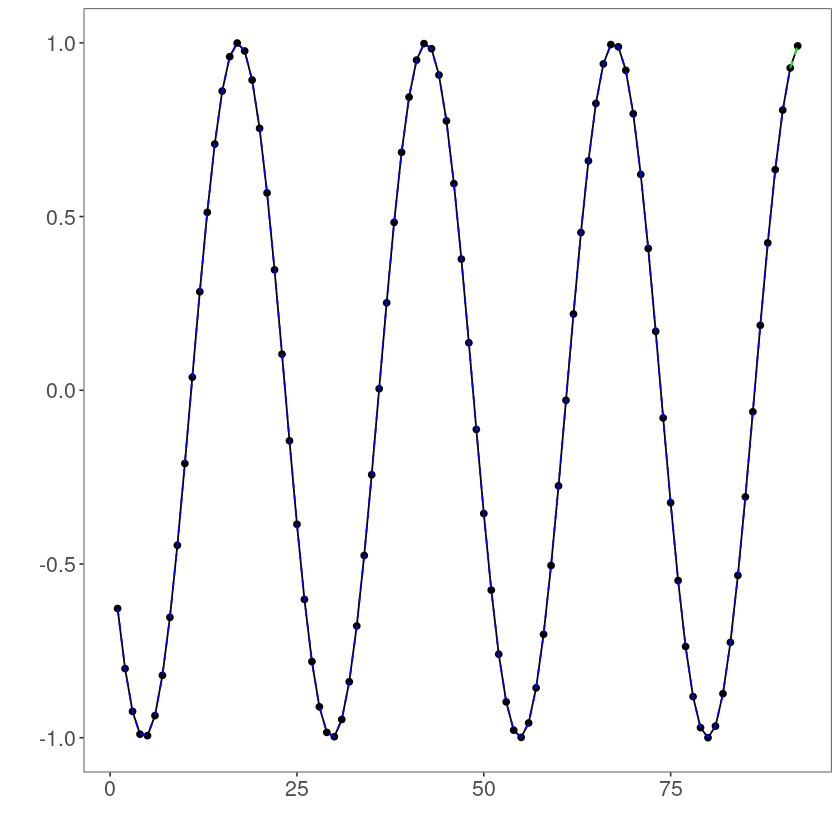

In [12]:
yvalues <- c(io_train$output, io_test$output)
plot_ts_pred(y=yvalues, yadj=adjust, ypre=prediction) + theme(text = element_text(size=16))

### Otions for machine learning

Options of ranges for all time series models:

In [13]:
### Ranges for ELM
ranges_elm <- list(nhid = 1:20, actfun=c('sig', 'radbas', 'tribas', 'relu', 'purelin'))

### Ranges for MLP
ranges_mlp <- list(size = 1:10, decay = seq(0, 1, 1/9), maxit=10000)

### Ranges for RF
ranges_rf <- list(nodesize=1:10, ntree=1:10)

### Ranges for SVM
ranges_svm <- list(kernel=c("radial", "poly", "linear", "sigmoid"), epsilon=seq(0, 1, 0.1), cost=seq(20, 100, 20))

### Ranges for LSTM
ranges_lstm <- list(input_size = 1:10, epochs=10000)

### Ranges for CNN
ranges_cnn <- list(input_size = 1:10, epochs=10000)